In [ ]:
#CAPSTONE 

In [1]:
import pandas as pd 
import matplotlib as plt
import numpy as np
import sklearn as sk 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from scipy.cluster import hierarchy
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, auc,\
roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.grid_search import GridSearchCV
import pickle as cPickle


from sklearn.neighbors import KNeighborsClassifier

/Users/punkymonkey/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1041: UserWarning: Duplicate key in file "/Users/punkymonkey/.matplotlib/matplotlibrc", line #2
  (fname, cnt))


In [2]:
lending_data_df = pd.read_csv('Lending_Club_Data_Cleaned.csv')

In [3]:
lending_data_df.head()

,loan_amnt,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,27500.0,C,C5,10+ years,MORTGAGE,195000.0,Not Verified,Fully Paid,other,LA,...,0.0,1.0,100.0,57.1,0.0,0.0,325100.0,44977.0,55500.0,13200.0
1,15850.0,F,F2,10+ years,OWN,45000.0,Not Verified,Current,debt_consolidation,OH,...,0.0,4.0,100.0,0.0,0.0,0.0,84300.0,45025.0,19900.0,43000.0
2,16000.0,C,C2,10+ years,MORTGAGE,65000.0,Not Verified,Current,small_business,AL,...,0.0,2.0,80.0,0.0,0.0,1.0,80999.0,39781.0,4700.0,71499.0
3,28000.0,D,D5,10+ years,MORTGAGE,75000.0,Verified,Current,debt_consolidation,IN,...,0.0,2.0,100.0,50.0,0.0,0.0,267312.0,57302.0,58500.0,31758.0
4,10000.0,C,C2,4 years,MORTGAGE,91392.0,Not Verified,Current,house,MO,...,0.0,3.0,100.0,100.0,0.0,0.0,321380.0,73732.0,4400.0,68648.0


In [4]:
#SHOWING A LIST OF TOTAL FEATURES USED HERE INCLUDING OUT TARGET WHICH IS THE "LOAN_STATUS" COLUMN

In [5]:
list(lending_data_df.columns)

['loan_amnt',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'loan_status',
 'purpose',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'recoveries',
 'collection_recovery_fee',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo

In [6]:
#BEGINNING TO PREPARE THE DATE SET BY FIRST LABEL ENCODING THOSE FEATURES I WANT TO BE REPRESENTED AS NUMBERS RATHER 
#THAN STRINGS.  LABEL ENCODING WILL ALSO ASSIGN VALUES TO THOSE NUMERIC COLUMNS.  

In [7]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

In [8]:
lending_data_df['grade'] = LabelEncoder().fit_transform(lending_data_df['grade'])
lending_data_df['sub_grade'] = LabelEncoder().fit_transform(lending_data_df['sub_grade'])
lending_data_df['emp_length'] = LabelEncoder().fit_transform(lending_data_df['emp_length'])
lending_data_df['verification_status'] = LabelEncoder().fit_transform(lending_data_df['verification_status'])


#look at doing dummies here rather than labelencoding 

In [9]:
#FOR HOME_OWNERSHIP AND PURPOSE I AM GOING TO USE PANDAS GET DUMMIES FUNCTION.  USING GET DUMMIES WILL ACHIEVE THE 
#SAME EFFECT AS LABEL ENCODER WITHOUT ASSIGNING A WEIGHTED VALUE TO THE CHOICES.  

In [10]:
home_ownership = pd.get_dummies(lending_data_df['home_ownership'])
purpose = pd.get_dummies(lending_data_df['purpose'])



In [11]:
#CREATING A NEW DATAFRAME INCLUDING THE DUMMY VERSIONS OF PURPOSE, AND HOMEOWNERSHIP WHILE DROPPING THE ORGINAL COLUMNS
lending_data_df = pd.concat([lending_data_df.drop(['purpose','home_ownership'],axis=1),
                             home_ownership, purpose], axis=1)

In [13]:
#CREATING TWO FUNCTION HERE, THE FIRST TO STRIP THE % SIGN FROM MY FLOATS AND SECOND CONVERT THEM TO DECIMAL PLACES.  
#THE SECOND FUNCTION IS FOR MY TARGET DATA SET WHERE I BREAK UP MY TARGETS CATEGORIES:

#THE TARGESTS ARE SET UP AS SO: 

# 'Fully Paid', 
# 'Current', 
# 'In Grace Period', 
# 'Late (31-120 days)',
# 'Late (16-30 days)', 
# 'Default',
# 'Charged Off'

#I AM CONVERTIGN THESE INTO SIMPLY GOOD AND BAD.  GOOD FOR PAYS OFF LOAN AND KEEPS CURRENT, WHICH INCLUDES THE CATEGORY
#'GRACE PERIOD' AND BAD FOR THE REMAINING. 



def loan_status_encoding(x):
    if x == 'Current':
        return 0
    elif x == 'In Grace Period':
        return 0
    elif x == 'Fully Paid':
        return 0
    else:
        return 1



In [14]:
#FUNCTION WHICH REMOVES PERCENTAGES AND RETURN DECIMALS

def int_rate_float_conv(x):
    if type(x) != float:
        return float(x.strip('%'))/100
    else:
        return x/100

In [15]:
lending_data_df['revol_bal'] = lending_data_df['revol_bal'].apply(int_rate_float_conv)

In [16]:
lending_data_df['revol_util'] = lending_data_df['revol_util'].apply(int_rate_float_conv)

#OR DOING THIS CALL USING LIST COMPRENSION WOULD GO:
#lending_data_df['revol_util'] = [lambda x: float(x.strip('%'))/100]

In [17]:
#USING STANDARD SCALER HERE TO SIMPLY SCALE MY FEATURES.  ALSO SETTING y AS MY TARGET HERE THEN CONVERTING USING 
#MY LOAN_STATUS_ENCODING(). 

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
y = lending_data_df['loan_status'].apply(loan_status_encoding)


In [20]:
#ALSO, I AM GOING TO SET ASIDE THE 'GRADE' FEATURE SO I CAN SEE IF I CAN CREATE A MODEL WHICH SCORES BETTER THAN THE 
#LENDING CLUD GRADE.  

In [21]:
X_grade = lending_data_df[['grade','sub_grade']]

In [22]:
grade_df = lending_data_df[['grade', 'loan_status']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fed185add10>]], dtype=object)

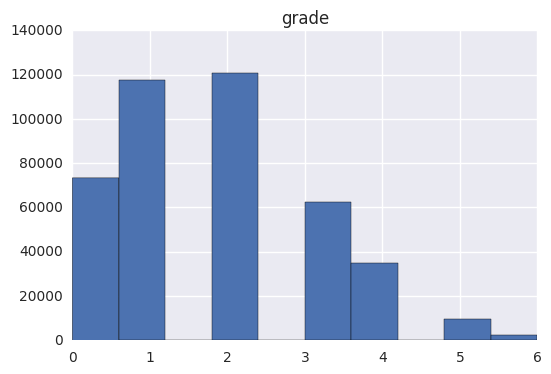

In [23]:
grade_df.hist()

In [24]:
grade_df1 = grade_df.pivot_table(index=['grade'], columns=['loan_status'], aggfunc=len)

In [25]:
grade_df1

loan_status,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
grade,,,,,,,
0,495,63032,28,9051,216,133,381
1,1766,98283,86,14898,767,439,1367
2,3729,95764,157,16259,1249,801,2608
3,3425,46797,133,8826,891,588,1994
4,2516,24954,88,4942,583,372,1493
5,1059,6256,34,1529,221,138,580
6,335,1181,13,400,47,44,147


In [26]:
#CREATING A DATAFRAME WHICH SHOWS THE PERCENTAGES AS RATIOS FOR EACH GRADE IN RELATION TO LOAN STATUS
#PERCENTIY WILL RETURN THE VALUE ATTACHED WITH A '%' TO MY RATIO.

percentify = lambda x: (x * 100).round(1).astype(str) + "%"

In [27]:
grade_list = grade_df1.columns

In [28]:
grade_percentages = (grade_df1[grade_list].T / grade_df1[grade_list].sum(axis=1)).T.pipe(percentify)

In [29]:
grade_percentages

loan_status,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
grade,,,,,,,
0,0.7%,85.9%,0.0%,12.3%,0.3%,0.2%,0.5%
1,1.5%,83.6%,0.1%,12.7%,0.7%,0.4%,1.2%
2,3.1%,79.4%,0.1%,13.5%,1.0%,0.7%,2.2%
3,5.5%,74.7%,0.2%,14.1%,1.4%,0.9%,3.2%
4,7.2%,71.4%,0.3%,14.1%,1.7%,1.1%,4.3%
5,10.8%,63.7%,0.3%,15.6%,2.3%,1.4%,5.9%
6,15.5%,54.5%,0.6%,18.5%,2.2%,2.0%,6.8%


In [30]:
#ABOVE WE CAN SEE JUDGING BY LENDING CLUB'S SCALE HOW CUSTOMERS, GIVEN A PARTICUL LETTER SCORE PAID BACK THEIR LOANS.

In [31]:
sub_grade = lending_data_df[['loan_status', 'sub_grade']]

In [32]:
sub_grade = sub_grade.pivot_table(index=['sub_grade'], columns=['loan_status'], aggfunc=len)

In [33]:
sub_grade

loan_status,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
sub_grade,,,,,,,
0,26.0,10991.0,4.0,1298.0,16.0,11.0,27.0
1,56.0,9932.0,3.0,1465.0,20.0,13.0,40.0
2,73.0,9329.0,4.0,1379.0,28.0,23.0,53.0
3,118.0,13180.0,3.0,2007.0,53.0,28.0,97.0
4,222.0,19600.0,14.0,2902.0,99.0,58.0,164.0
5,230.0,18945.0,7.0,2569.0,103.0,71.0,171.0
6,256.0,18700.0,14.0,2774.0,125.0,74.0,228.0
7,332.0,20772.0,19.0,2956.0,172.0,82.0,304.0
8,431.0,20745.0,20.0,3336.0,188.0,96.0,305.0


In [34]:
sub_grade_list = sub_grade.columns

In [35]:
sub_grade_percentages = (sub_grade[sub_grade_list].T / sub_grade[sub_grade_list].sum(axis=1)).T.pipe(percentify)

In [36]:
sub_grade_percentages

loan_status,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
sub_grade,,,,,,,
0,0.2%,88.8%,0.0%,10.5%,0.1%,0.1%,0.2%
1,0.5%,86.1%,0.0%,12.7%,0.2%,0.1%,0.3%
2,0.7%,85.7%,0.0%,12.7%,0.3%,0.2%,0.5%
3,0.8%,85.1%,0.0%,13.0%,0.3%,0.2%,0.6%
4,1.0%,85.0%,0.1%,12.6%,0.4%,0.3%,0.7%
5,1.0%,85.7%,0.0%,11.6%,0.5%,0.3%,0.8%
6,1.2%,84.3%,0.1%,12.5%,0.6%,0.3%,1.0%
7,1.3%,84.3%,0.1%,12.0%,0.7%,0.3%,1.2%
8,1.7%,82.6%,0.1%,13.3%,0.7%,0.4%,1.2%


In [37]:
#LOOKING AT THE PERCENTAGES OF SUB_GRADE SCORES THAT GO INTO DEFAULT ARE THE LOWER SCORES.  CONVERSLY ALSO THE A COUPLE
#OF THE LOWER CATEGORIES G1, G2, G3, AND G4 HAVE THE HIGHEST PERCENTAGE OF FULLY-PAID LOANS STATUS

In [38]:
annual_inc_df = lending_data_df[['loan_status','annual_inc']]

In [39]:
annual_inc_df['loan_status'] = annual_inc_df['loan_status'].apply(loan_status_encoding)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [40]:
annual_inc_df.groupby('loan_status').mean()

,annual_inc
loan_status,
0,77328.806669
1,71198.666601


In [41]:
#LOOKING AT ANNUAL INCOME I CANNOT SEEM TO FIGURE OUT A WAY TO CONDENSE OR MANIPULATE TO LOOSE ANY POSSIBLE NOISE 
#BEFORE BUILDING OUT THE MODELS 

In [42]:
#HOW DOES THE FICO SCORE COMPARE WITH THE LOAN STATUS 

In [43]:
fico_score_df = lending_data_df[['loan_status','last_fico_range_high']]

In [44]:
fico_score_df['loan_status'] = fico_score_df['loan_status'].apply(loan_status_encoding)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


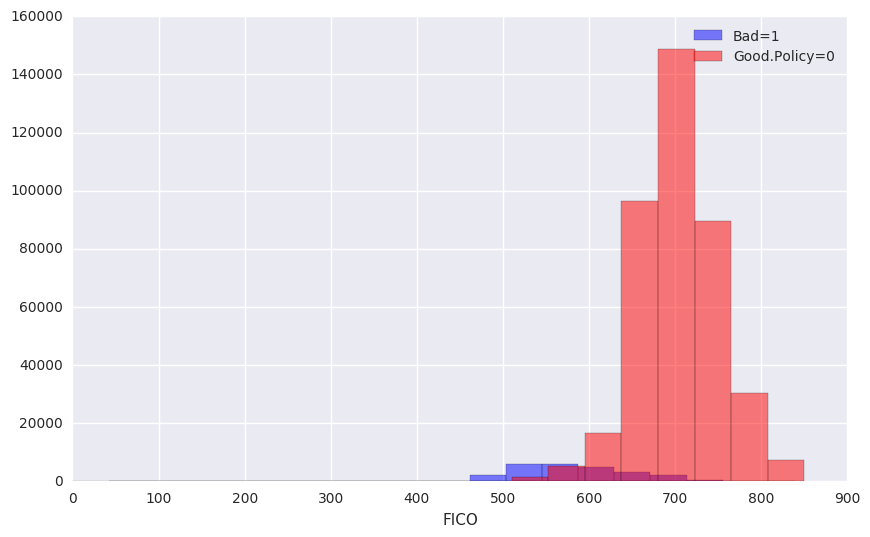

In [45]:
plt.figure(figsize=(10,6))
fico_score_df[fico_score_df['loan_status']==1]['last_fico_range_high'].hist(alpha=0.5,color='blue',
                                              bins=20,label='Bad=1')
fico_score_df[fico_score_df['loan_status']==0]['last_fico_range_high'].hist(alpha=0.5,color='red',
                                              bins=20,label='Good.Policy=0')
plt.legend()
plt.xlabel('FICO')

In [46]:
#ABOVE WE SEE A FICO SCORE BELOW 530 OR SO WAS IN THE BAD CATEGORY 

In [47]:
lending_data_df.drop(['loan_status'], axis=1,inplace=True)
#lending_data_df.drop(['application_type','annual_inc_joint','dti_joint'], axis=1, inplace=True)

In [48]:
#SAVING THE STATE COLUMN.  MAYBE LOOKING TO USE TABLAU TO SEE WHICH STATES, IF ANY HAVE MORE CHARGE OFF OR DEFAULT
#APPLLCATNS. 

In [49]:
states_df = lending_data_df['addr_state']

In [50]:
lending_data_df.drop(['addr_state'], axis=1, inplace=True)

In [51]:
#SETTING MY X TO BE A DATAFRAME SCALED USING STANDARDSCALER

In [52]:
X = pd.DataFrame(StandardScaler().fit_transform(lending_data_df), columns=lending_data_df.columns)

In [53]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421095 entries, 0 to 421094
Data columns (total 96 columns):
loan_amnt                         421095 non-null float64
grade                             421095 non-null float64
sub_grade                         421095 non-null float64
emp_length                        421095 non-null float64
annual_inc                        421095 non-null float64
verification_status               421095 non-null float64
dti                               421095 non-null float64
delinq_2yrs                       421095 non-null float64
fico_range_low                    421095 non-null float64
fico_range_high                   421095 non-null float64
inq_last_6mths                    421095 non-null float64
mths_since_last_delinq            421095 non-null float64
mths_since_last_record            421095 non-null float64
open_acc                          421095 non-null float64
pub_rec                           421095 non-null float64
revol_bal          

In [54]:
# RUNNING A PCA TO SEE IF I CAN REDUCE THE DIMENSIONALITY OF THE DATASET AND ALSO SPOT ANY NEW CLUSTERS. 

In [81]:
from sklearn.decomposition import PCA

In [82]:
X.shape

(421095, 96)

In [83]:
pca = PCA(n_components=2)

In [84]:
X_pca = pca.fit_transform(X)

In [85]:
#CREATING A DATAFRAME WHICH SHOWS THE RESULTS OF OUR PCA.  

X_pca_df = pd.DataFrame(pca.fit_transform(X), columns=['PC1', 'PC2'])

In [86]:
X_pca_df

,PC1,PC2
0,4.594763,6.160861
1,5.000779,12.513003
2,0.981838,9.275857
3,10.556044,6.222866
4,3.899872,11.960417
5,4.985985,11.603667
6,4.371975,4.661260
7,10.474917,7.309323
8,2.665080,6.009112
9,8.470678,9.638194


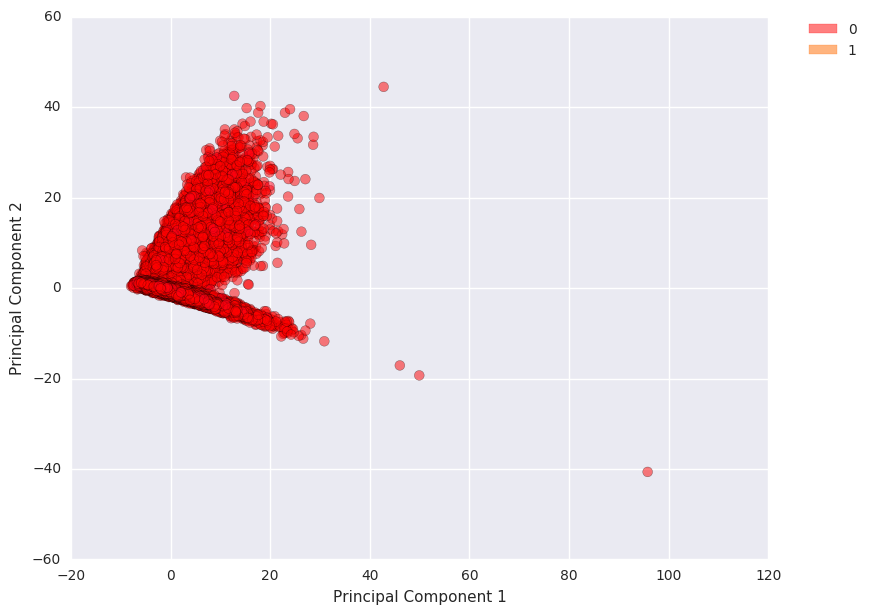

In [87]:
fig , ax1 = plt.subplots(figsize=(9,7))


color_idx = pd.factorize(y)[0]
cmap = plt.cm.hsv

ax1.scatter(X_pca_df.iloc[:,0], X_pca_df.iloc[:,1], c=color_idx, cmap=cmap, alpha=0.5, s=50)
ax1.set_ylabel('Principal Component 2')


# Custom legend for the classes (y) since we do not create scatter plots per class (which could have their own labels).
handles = []
labels = pd.factorize(y.unique())
norm = mpl.colors.Normalize(vmin=0.0, vmax=14.0)

for i, v in zip(labels[0], labels[1]):
    handles.append(mpl.patches.Patch(color=cmap(norm(i)), label=v, alpha=0.5))

ax1.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# xlabel for both plots
for ax in fig.axes:
    ax.set_xlabel('Principal Component 1')    

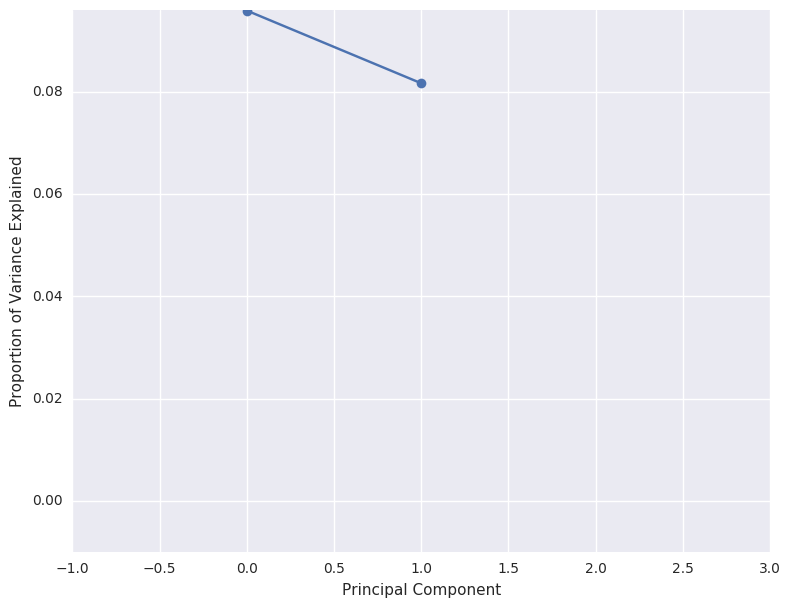

In [88]:
fig , ax1 = plt.subplots(figsize=(9,7))

ax1.plot(pca.explained_variance_ratio_, '-o')
ax1.set_ylabel('Proportion of Variance Explained')
ax1.set_ylim(ymin=-0.01)

for ax in fig.axes:
    ax.set_xlabel('Principal Component')
    ax.set_xlim(-1,3)    

In [89]:
components = pca.components_

In [90]:
components

array([[  1.16416390e-01,  -3.78725117e-02,  -3.93096258e-02,
         -2.52901679e-02,   9.51759206e-02,   9.93543343e-03,
          2.49861971e-02,   1.72614912e-03,   6.88640947e-02,
          6.88637445e-02,   6.00100402e-02,  -8.06475487e-04,
         -2.15762232e-02,   2.61209891e-01,  -1.85083685e-02,
          1.47852654e-01,  -6.90734438e-02,   2.38535026e-01,
         -2.93141811e-03,  -3.05080381e-03,   5.33488178e-02,
          4.85714763e-02,  -4.06045147e-03,  -6.79965488e-03,
          4.64984407e-03,  -2.18454536e-04,   1.58352190e-01,
          9.34094142e-02,   8.56116527e-02,   8.13920079e-02,
          9.10593739e-02,   3.44696784e-02,   9.01527186e-02,
          9.03518566e-02,   9.31627211e-02,   9.95097013e-02,
          8.06178655e-02,   8.30652080e-02,   2.01925842e-01,
          6.97089029e-02,   6.06358555e-02,   8.59633786e-02,
          1.51333670e-01,   5.26914636e-02,   1.69826969e-01,
         -6.65727218e-02,   1.81401964e-03,   1.18221104e-03,
        

In [91]:
pca_components = pd.DataFrame(components.T, index=lending_data_df.columns, 
                            columns=['PC1','PC2'])


In [92]:
pca_components

,PC1,PC2
loan_amnt,0.116416,-0.053255
grade,-0.037873,0.039772
sub_grade,-0.039310,0.040886
emp_length,-0.025290,0.010891
annual_inc,0.095176,-0.034498
verification_status,0.009935,0.005660
dti,0.024986,-0.001173
delinq_2yrs,0.001726,0.004201
fico_range_low,0.068864,-0.052542
fico_range_high,0.068864,-0.052542


In [93]:
#HEATMAPS. DISCUSS IN PAPER THE SIGNIFICANCE AND ANALSIS.  

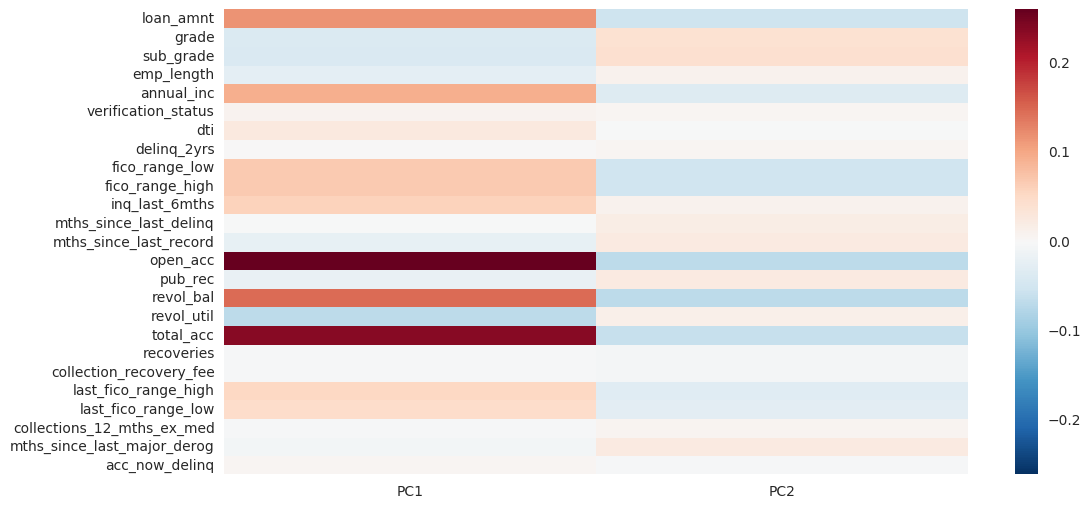

In [94]:
plt.figure(figsize=(12,6))
sns.heatmap(pca_components[0:25])

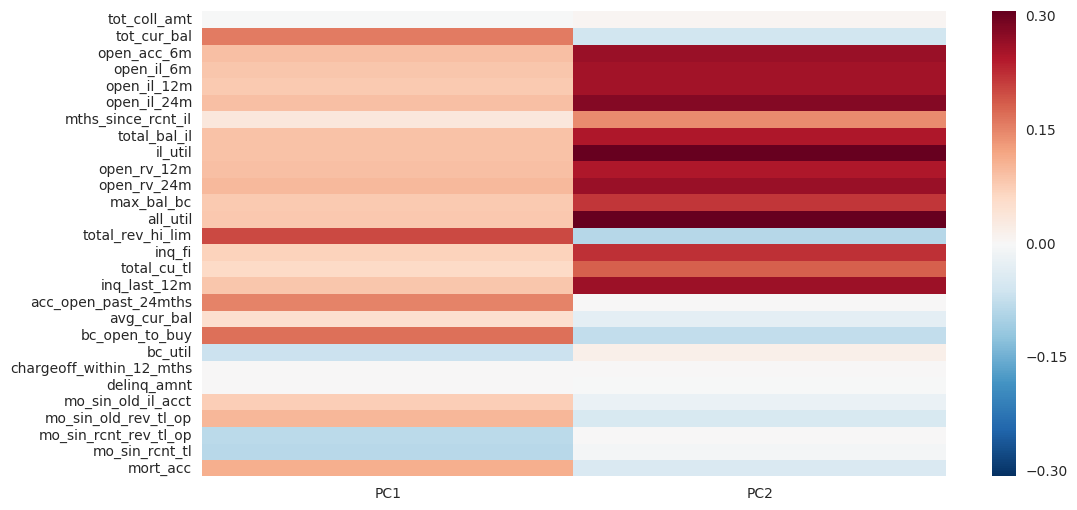

In [95]:
plt.figure(figsize=(12,6))
sns.heatmap(pca_components[25:53])

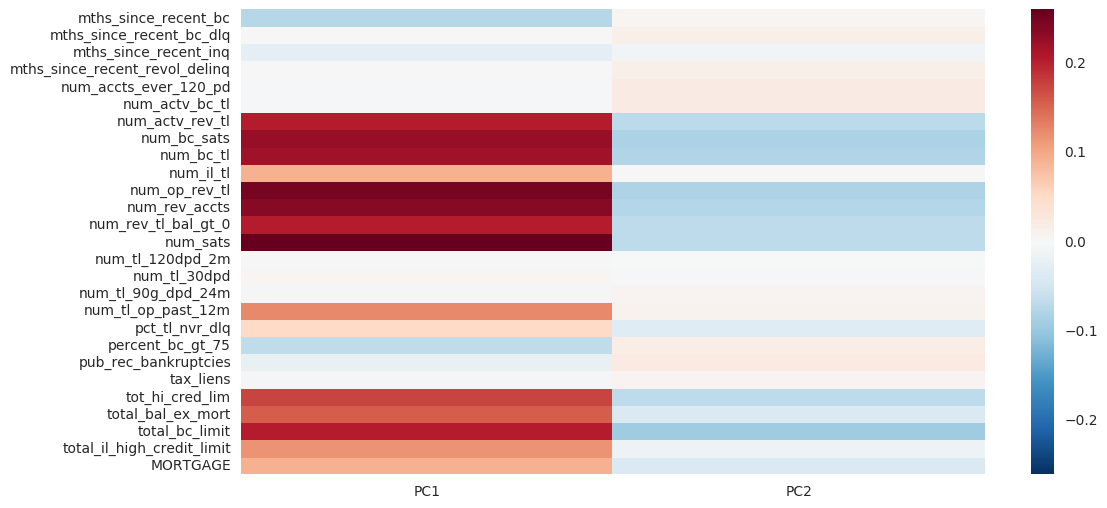

In [96]:
plt.figure(figsize=(12,6))
sns.heatmap(pca_components[53:80])

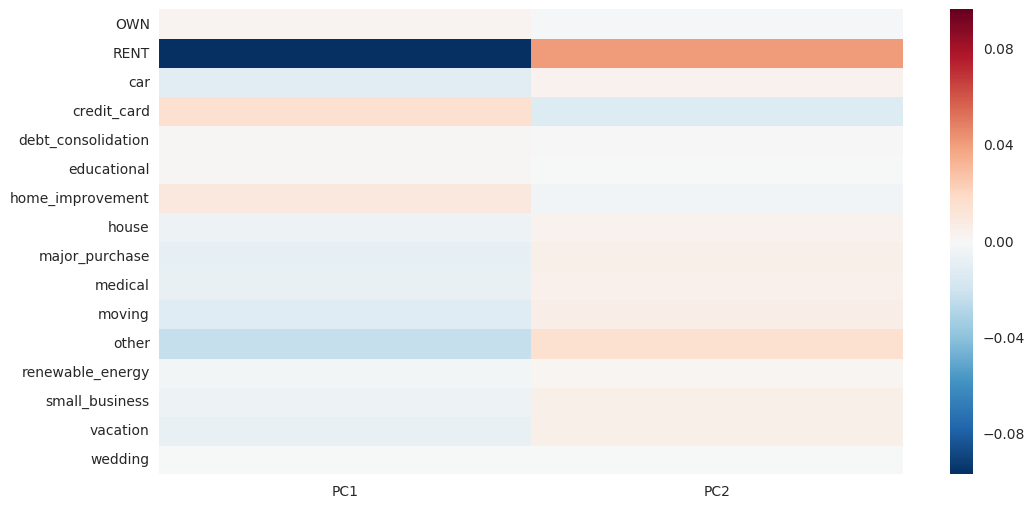

In [97]:
plt.figure(figsize=(12,6))
sns.heatmap(pca_components[80:])

In [98]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [99]:
kmeans = KMeans(n_clusters=2)

In [100]:
kmeans.fit(X_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [101]:
pd.DataFrame(kmeans.labels_, columns=['clst'])['clst'].value_counts()

0    403074
1     18021
Name: clst, dtype: int64

In [102]:
y.value_counts()

0    396146
1     24949
Name: loan_status, dtype: int64

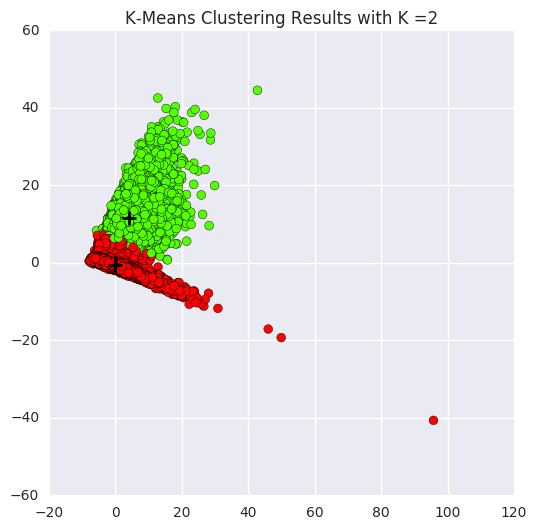

In [103]:
fig, (ax1) = plt.subplots(1, figsize=(6,6))

ax1.scatter(X_pca[:,0], X_pca[:,1], s=40, c=kmeans.labels_, cmap=plt.cm.prism) 
ax1.set_title('K-Means Clustering Results with K =2')
ax1.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],marker='+', s=100, c='k', linewidth=2)



In [104]:
# with open('Grade_model', 'wb') as picklefile:
#     cPickle.dump(logistic_model(X_grade_df,y ), picklefile)

In [105]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score, StratifiedKFold

In [106]:
#HERE I AM GOING TO DO A COUPLE OF TEST MODELS.  THE FIRST OF WHICH BEING HOW WELL THE DATA SETS PREDICTS DEFAULT 
#THE STANDARD LETTER GRADE ASSIGNED BY LENDING CLUB.  THE SECOND MODEL USING THE PCA. 

In [107]:
cv = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=88)

In [108]:
#BUILDING A FEW PRINTING FUNCTIONS.  THE FIRST PRINTING THE METRICS OF THE MODEL.  CLASSIFICAITON REPORTS, CONFUSION 
#MATRICES. 

In [109]:
def print_metrics(X, y, y_pred, y_test, X_test, model): 
    Metrics = {}
    
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))
    
    
    #CONVERTING THE CONFUSION MATRIX CALLED ABOVE INTO AN EASILY READABLE DATAFRAME
    confusion = pd.DataFrame(conmat, index=["Good","Bad"], columns = ["Predicted Good","Predicted Bad"])
    
     
    
    #PRINTING ACCURACY, PRECISION, RECALL, FALSE POSTIVIE RATE, AREAS UNDER ROC CURVE AND P-R CURVE FOR EACH MODEL
    print "Train/Test Metrics:"
    print "Accuracy:\t\t %.4f" %(accuracy_score(y_test, y_pred))
    print "Precision:\t\t %.4f" %(precision_score(y_test, y_pred))
    print "Recall:\t\t\t %.4f" %recall_score(y_test, y_pred)
    print "False Positive Rate:\t %.4f" %(float(confusion.iloc[0,1])/(confusion.iloc[0,1]+confusion.iloc[0,0]))
    print "Area Under ROC Curve:\t %.4f" %roc_auc_score(y_test, model.predict_proba(X_test).T[1])
    prec, recall, thresh = precision_recall_curve(y_test, model.predict_proba(X_test).T[1])
    print "Area Under P-R Curve:\t %.4f" %auc(recall, prec)    
    print "\n"
    
    #CONFUSION MATRIX PRINT OUT
    print confusion
    print '\n'
    
    #CLASSIFICATION REPORT PRINT OUT 
    print classification_report(y_pred, y_test)
    
    Metrics = {'Accuracy': accuracy_score(y_test, y_pred),
               'Precision': precision_score(y_test,y_pred),
               'Recall': recall_score(y_test, y_pred),
               'False Positve Rate': (float(confusion.iloc[0,1])/(confusion.iloc[0,1]+confusion.iloc[0,0])),
               'Area Under Roc Curve': roc_auc_score(y_test,model.predict_proba(X_test).T[1]),
               'Area Under P-R Curve': auc(recall, prec)}
    return Metrics

In [110]:
#PRINT THE COEFICIENTS OF EACH MODEL TO SEE HOW EACH FEATURE CONTRIBUES

def print_coefs(X, model):
    print "Train/Test Model Coefficients:"
    print pd.DataFrame({"feature":X.columns.values,"coef":model.coef_[0]})
    return pd.DataFrame({"feature":X.columns.values,"coef":model.coef_[0]})

In [111]:
#PRINT THE CROSSVAL SCORE FOR EACH MODEL 

def print_crossval(model, X, y, cv):
    cv = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=88)
    print "Cross Val Scoring:"
    
    m = np.mean(cross_val_score(model, X, y, cv=cv))
    s = np.std(cross_val_score(model, X, y, cv=cv))
    print ("Mean accuracy score from cross validation:\t{:0.3} ± {:0.3}".format(round(m,3), round(s,3)))

In [112]:
#PRINT THE PROBABILITY OF PREDICTION FOR EACH MODEL 

def print_proba_pred(y, model, X_test):
    
    print zip (y.unique(),model.predict_proba(X_test))

In [113]:
def auc_plotting_function(rate1, rate2, rate1_name, rate2_name, curve_name):
    AUC = auc(rate1, rate2)
    # Plot of a ROC curve for class 1 Bad (Default, Charged Off, Late)
    plt.figure(figsize=[6,6])
    plt.plot(rate1, rate2, label=curve_name + ' (area = %0.4f)' % AUC, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(rate1_name, fontsize=18)
    plt.ylabel(rate2_name, fontsize=18)
    plt.title(curve_name + ' ROC Curve', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

# plot receiving operator characteristic curve
def plot_roc(y_test, y_score):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_plotting_function(fpr, tpr, 'False Positive Rate', 'True Positive Rate', 'ROC')



Creating a logistic regression model using both the grade and sub-grade lendingclub.com presents to investors.  Both scores have been lable encoded yeilding weight to their values.  

In [114]:
X_grade_df = pd.DataFrame(StandardScaler().fit_transform(X_grade), columns=X_grade.columns)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X_grade_df, y, test_size=0.20, stratify=y, random_state=88)    

log_model_grade =  LogisticRegression(class_weight='balanced')

In [116]:
# log_model_grade.fit(X_train, y_train)

# with open('Lending_Club_model', 'wb') as picklefile:
#     cPickle.dump(log_model_grade, picklefile)

In [117]:
with open('Lending_Club_model', 'rb') as picklefile:
    log_model_grade = cPickle.load(picklefile)

In [118]:
y_pred_grade = log_model_grade.predict(X_test)

In [119]:
grade_metrics = print_metrics(X_grade_df, y, y_pred_grade, y_test ,X_test, log_model_grade)

Train/Test Metrics:
Accuracy:		 0.6534
Precision:		 0.1046
Recall:			 0.6413
False Positive Rate:	 0.3458
Area Under ROC Curve:	 0.7055
Area Under P-R Curve:	 0.1254


      Predicted Good  Predicted Bad
Good           51828          27401
Bad             1790           3200


             precision    recall  f1-score   support

          0       0.65      0.97      0.78     53618
          1       0.64      0.10      0.18     30601

avg / total       0.65      0.65      0.56     84219



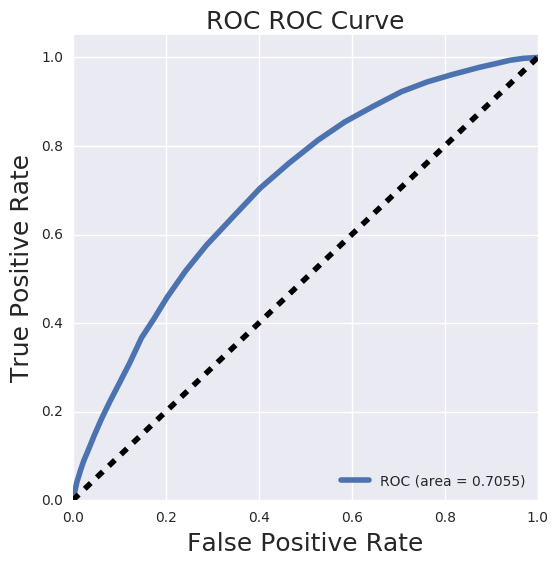

In [120]:
Y_score = log_model_grade.decision_function(X_test)
plot_roc(y_test, Y_score)

In [121]:
grade_coef = print_coefs(X_grade_df, log_model_grade)

Train/Test Model Coefficients:
       coef    feature
0 -0.033320      grade
1  0.766563  sub_grade


In [746]:
print_crossval(log_model_grade, X_grade_df, y, cv)

Cross Val Scoring:
Mean accuracy score from cross validation:	0.653 ± 0.001


In [122]:
print_proba_pred(y, log_model_grade, X_test)

[(0, array([ 0.77521309,  0.22478691])), (1, array([ 0.79524447,  0.20475553]))]


In [ ]:
#The sub-grade yieled the stronger effect on the model here.  
#Interesting enough the model yeilds no recall, or precision score.   
#Trimming some features down I believe I can make a better model. 

In [ ]:
 #The next model to train is another logistic regression using the pca results.  

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X_pca_df, y, test_size=0.20, random_state=88)    

log_model_pca =  LogisticRegression(class_weight='balanced')

In [124]:
# log_model_pca.fit(X_train, y_train)

# with open('PCA_model', 'wb') as picklefile:
#     cPickle.dump(log_model_pca, picklefile)

USING PICKLE HERE TO SAVE AND RECALL MY MODEL

In [125]:
with open('PCA_model', 'rb') as picklefile:
    pca_model = cPickle.load(picklefile)

In [126]:
y_pred_pca = pca_model.predict(X_test)

In [127]:
pca_metrics = print_metrics(X_pca_df, y, y_pred_pca, y_test, X_test, pca_model)

Train/Test Metrics:
Accuracy:		 0.4764
Precision:		 0.0672
Recall:			 0.5978
False Positive Rate:	 0.5314
Area Under ROC Curve:	 0.5499
Area Under P-R Curve:	 0.0724


      Predicted Good  Predicted Bad
Good           37088          42059
Bad             2040           3032


             precision    recall  f1-score   support

          0       0.47      0.95      0.63     39128
          1       0.60      0.07      0.12     45091

avg / total       0.54      0.48      0.36     84219



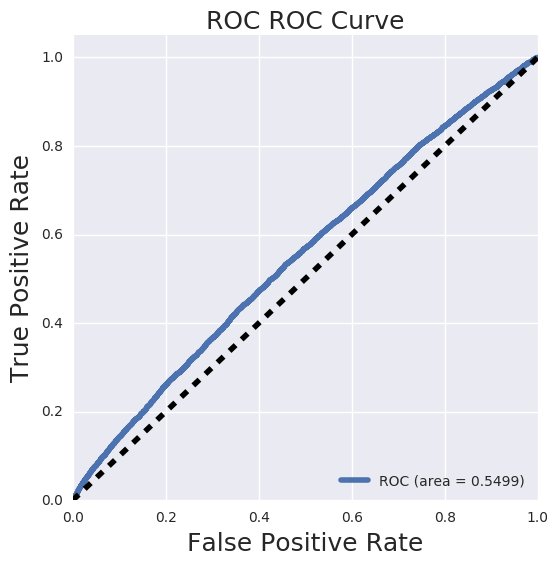

In [128]:
Y_score = pca_model.decision_function(X_test)
plot_roc(y_test, Y_score)

In [129]:
pca_coef = print_coefs(X_pca_df, pca_model)

Train/Test Model Coefficients:
       coef feature
0 -0.058636     PC1
1  0.004518     PC2


In [660]:
pca_cross_val_score = print_crossval(pca_model, X_pca_df, y, cv)

Cross Val Scoring:
Mean accuracy score from cross validation:	0.479 ± 0.002


In [130]:
pca_proba = print_proba_pred(y, pca_model, X_test)

[(0, array([ 0.57118169,  0.42881831])), (1, array([ 0.46721438,  0.53278562]))]


In [131]:
#COMPARE WITH PCA COMPONENTS HERE

RUNNING A LOGISTIC REGRESSION MODEL SPECIFING LASSO PENALTY TO SCALE THE FEATURES LIST DOWN.  

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=88)    
log_model =  LogisticRegression(n_jobs=-1, penalty='l1', class_weight='balanced')

COMMENTING OUT NO NEED TO RUN A FIT, JUST PICKLE IN MODEL.

In [192]:
# log_model.fit(X_train, y_train)

# with open('full_lasso_model', 'wb') as picklefile:
#     cPickle.dump(log_model, picklefile)

In [136]:
with open('full_lasso_model','rb') as picklefile:
    banana = cPickle.load(picklefile)

USING PICKLE HERE TO SAVE AND RECALL MY MODEL

In [137]:
banana

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [138]:
y_pred_lasso = banana.predict(X_test)

In [139]:
lasso_metrics = print_metrics(X, y, y_pred_lasso, y_test, X_test, banana)

Train/Test Metrics:
Accuracy:		 0.9084
Precision:		 0.3771
Recall:			 0.8385
False Positive Rate:	 0.0872
Area Under ROC Curve:	 0.9407
Area Under P-R Curve:	 0.7413


      Predicted Good  Predicted Bad
Good           72319           6910
Bad              806           4184


             precision    recall  f1-score   support

          0       0.91      0.99      0.95     73125
          1       0.84      0.38      0.52     11094

avg / total       0.90      0.91      0.89     84219



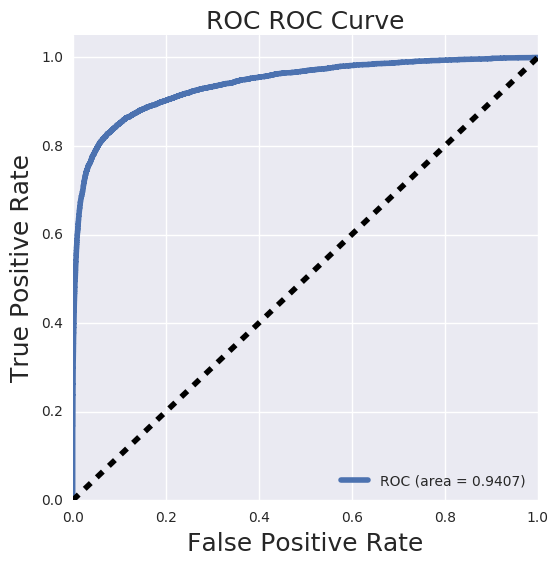

In [140]:
Y_score = banana.decision_function(X_test)
plot_roc(y_test, Y_score)

In [141]:
print_proba_pred(y, banana, X_test)

[(0, array([ 0.7965926,  0.2034074])), (1, array([ 0.9978627,  0.0021373]))]


In [142]:
lasso_coef = print_coefs(X, banana)

Train/Test Model Coefficients:
        coef                      feature
0   0.343575                    loan_amnt
1  -0.020113                        grade
2   0.247199                    sub_grade
3   0.085801                   emp_length
4  -0.025838                   annual_inc
5   0.046332          verification_status
6   0.358467                          dti
7   0.031989                  delinq_2yrs
8   0.205039               fico_range_low
9   0.162737              fico_range_high
10  0.009278               inq_last_6mths
11 -0.009820       mths_since_last_delinq
12  0.071892       mths_since_last_record
13 -0.313676                     open_acc
14 -0.029345                      pub_rec
15 -0.115595                    revol_bal
16 -0.084937                   revol_util
17 -0.246760                    total_acc
18  4.371092                   recoveries
19  6.734809      collection_recovery_fee
20 -2.058328         last_fico_range_high
21  0.000942          last_fico_range_low
22 

In [200]:
print_crossval(banana, X, y, cv)

Cross Val Scoring:
Mean accuracy score from cross validation:	0.909 ± 0.001


In [143]:
print_proba_pred(y, banana, X_test)

[(0, array([ 0.7965926,  0.2034074])), (1, array([ 0.9978627,  0.0021373]))]


LOOKING OVER THE COEFICIENTS OF THE FEATURES TO SEE WHICH FEATURES CONTRIBUTE MOST TO THE MODEL. 

In [144]:
#HERE I CUT THE FEATURE LEAST DOWN.  DROPPING THOSE FEATURES WHO'S COEFFICIENTS ARE LESS THAN 0.002

feature_list_highs = lasso_coef[np.abs(lasso_coef['coef']) > 0.002]

In [145]:
feature_list_highs

,coef,feature
0,0.343575,loan_amnt
1,-0.020113,grade
2,0.247199,sub_grade
3,0.085801,emp_length
4,-0.025838,annual_inc
5,0.046332,verification_status
6,0.358467,dti
7,0.031989,delinq_2yrs
8,0.205039,fico_range_low
9,0.162737,fico_range_high


In [146]:
feature_list_highs['coef_abs'] = np.abs(feature_list_highs['coef'])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [147]:
feature_list_highs = feature_list_highs.sort_values('coef_abs', ascending=False)

In [148]:
feature_list_highs
#LOOKING AT THE ABSOLUTE VALUE I CAN SEE WHICH FEATURES START TO CONTRIBUTE MOST TOWARDS OUR MODELS PREDICTIONS. 

#COLLETION_RECOVER_FEE
#LAST_FICO_RANGE_HIGH
#RECOVERIES

,coef,feature,coef_abs
19,6.734809,collection_recovery_fee,6.734809
18,4.371092,recoveries,4.371092
20,-2.058328,last_fico_range_high,2.058328
6,0.358467,dti,0.358467
0,0.343575,loan_amnt,0.343575
13,-0.313676,open_acc,0.313676
66,0.297826,num_sats,0.297826
64,0.263455,num_rev_accts,0.263455
2,0.247199,sub_grade,0.247199
17,-0.246760,total_acc,0.246760


In [149]:
#Cutting down the features list.  Cutting away those features with coefficients less than 0.002.  

feature_list_abs = lasso_coef[np.abs(lasso_coef['coef']) < 0.002 ]

In [150]:
feature_list_abs

,coef,feature
21,0.000942,last_fico_range_low
22,0.001256,collections_12_mths_ex_med
55,0.000749,mths_since_recent_inq
58,0.000000,num_actv_bc_tl
84,0.000000,debt_consolidation


In [151]:
to_cut = list(feature_list_abs.feature)

In [152]:
#TO_CUT: MY LIST OF FEATURES TO TRIM BASED ON LOW COEFFICIENT SCORES. 

to_cut

['last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_recent_inq',
 'num_actv_bc_tl',
 'debt_consolidation']

In [153]:
#LOOKING OVER A FEW OF THE FEATURES IN THE TO_CUT LIST TO SEE IF THERE ARE ANY INTESTING OR NON INTERESTING ITEMS.

In [161]:
trim = ['last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_recent_inq',
 'num_actv_bc_tl',
 'debt_consolidation','loan_status']

trim_df = lending_data_df[['last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_recent_inq',
 'num_actv_bc_tl',
 'debt_consolidation']]

trim_df

trim_df.info()

trim_df['collections_12_mths_ex_med'].value_counts()

collection = pd.concat([trim_df['collections_12_mths_ex_med'], y], axis=1)

collection = collection.pivot_table(index=['collections_12_mths_ex_med'], columns=['loan_status'], aggfunc=len)

collection

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421095 entries, 0 to 421094
Data columns (total 5 columns):
last_fico_range_low           421095 non-null float64
collections_12_mths_ex_med    421095 non-null float64
mths_since_recent_inq         421095 non-null float64
num_actv_bc_tl                421095 non-null float64
debt_consolidation            421095 non-null uint8
dtypes: float64(4), uint8(1)
memory usage: 13.3 MB


loan_status,0,1
collections_12_mths_ex_med,,
0.0,388942.0,24386.0
1.0,6639.0,520.0
2.0,479.0,34.0
3.0,62.0,7.0
4.0,14.0,2.0
5.0,6.0,NaN
6.0,1.0,NaN
7.0,1.0,NaN
10.0,1.0,NaN


In [162]:
#LOOKS LIKE CHARGED OFF AND DEFAULT AND LATES.  ANYONE WITH 5 COLLECTIONS OR MORE WERE NEITHER LATE, 
#DEFAULT OR CHARGED OFF.  SO APPLICANTS WITH THESE LATE MEDICAL BILLS SEEM TO HAVE NO EFFECT NEGATIVELY ON THEIR
#REPAYMENT.  HAVE TO DELVE INTO MEDICAL BILLS MORE.

In [163]:
#THE RENT FEATURE LOOKS TO PROVIDE NO INFO TOWARDS OUR TARGET 

In [127]:
#A DATAFRAME DETAILING THE COEFFICIENTS OF FEATURES GREATER THAN 0.002 FROM HIGHEST TO LOWEST.   

#LOAN_AMNT, COLLECTION_RECOVERY_FEE, RECOVERIES, AND FICO_RANGE_HIGH 
positive_correlation_df = lasso_coef[lasso_coef['coef'] > 0.002]

In [128]:
positive_correlation_df.sort_values('coef', ascending=False)

,coef,feature
19,6.734809,collection_recovery_fee
18,4.371092,recoveries
6,0.358467,dti
0,0.343575,loan_amnt
66,0.297826,num_sats
64,0.263455,num_rev_accts
2,0.247199,sub_grade
62,0.210933,num_il_tl
8,0.205039,fico_range_low
71,0.169911,pct_tl_nvr_dlq


In [129]:
#THE FEATURES WITH NEGATIVE COEFFICIENTS CONTRIBUTING TOWARDS THE MODEL PREDICTIONS.  

negative_correlation_df = lasso_coef[lasso_coef['coef'] < -0.002]

In [130]:
negative_correlation_df.sort_values('coef')

,coef,feature
20,-2.058328,last_fico_range_high
13,-0.313676,open_acc
17,-0.246760,total_acc
26,-0.127651,tot_cur_bal
15,-0.115595,revol_bal
78,-0.112625,total_il_high_credit_limit
65,-0.096363,num_rev_tl_bal_gt_0
16,-0.084937,revol_util
35,-0.063158,open_rv_24m
60,-0.059717,num_bc_sats


In [131]:
X_cut = X.drop(to_cut, axis=1)

In [132]:
#MY NEW LIST OF COLUMNS

In [133]:
list(X_cut.columns)

['loan_amnt',
 'grade',
 'sub_grade',
 'emp_length',
 'annual_inc',
 'verification_status',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'recoveries',
 'collection_recovery_fee',
 'last_fico_range_high',
 'mths_since_last_major_derog',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_revol_delinq',


In [134]:
#NEXT USING A DECISION TREE CLASSIFIER TO PREDICT

In [147]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X_cut, y, test_size=0.20, stratify=y, random_state=88)

In [149]:
dt_model = DecisionTreeClassifier(class_weight='balanced',)

In [ ]:
#try to add in graphical respresnttion here 

In [150]:
# dt_model.fit(X_train, y_train)

# with open('Decision_tree_model','wb') as picklefile:
#     cPickle.dump(dt_model, picklefile)

In [151]:
with open('Decision_tree_model', 'rb') as picklefile:
    dt_model = cPickle.load(picklefile)

In [522]:
print_crossval(dt_model,X_cut,y,cv)

Cross Val Scoring:
Mean accuracy score from cross validation:	0.945 ± 0.0


In [152]:
y_pred_dt = dt_model.predict(X_test)

In [153]:
dt_metrics = print_metrics(X_cut, y, y_pred_dt, y_test, X_test, dt_model)

Train/Test Metrics:
Accuracy:		 0.9449
Precision:		 0.5351
Recall:			 0.5355
False Positive Rate:	 0.0293
Area Under ROC Curve:	 0.7531
Area Under P-R Curve:	 0.5491


      Predicted Good  Predicted Bad
Good           76908           2321
Bad             2318           2672


             precision    recall  f1-score   support

          0       0.97      0.97      0.97     79226
          1       0.54      0.54      0.54      4993

avg / total       0.94      0.94      0.94     84219



In [160]:
print_proba_pred(y, dt_model, X_test)

[(0, array([ 1.,  0.])), (1, array([ 1.,  0.]))]


In [161]:
dt_df = pd.DataFrame({"feature":X_cut.columns.values,"importance":dt_model.feature_importances_})

In [162]:
dt_df.sort_values('importance', ascending=False)

,feature,importance
20,last_fico_range_high,0.600122
0,loan_amnt,0.021032
47,mo_sin_old_rev_tl_op,0.017878
6,dti,0.017778
46,mo_sin_old_il_acct,0.014440
16,revol_util,0.013598
4,annual_inc,0.013253
15,revol_bal,0.011750
2,sub_grade,0.011248
43,bc_util,0.010855


In [163]:
decision_tree_feature_importance_df = dt_df[dt_df['importance'] > 0.002]

In [164]:
decision_tree_feature_importance_df.sort_values('importance', ascending=False)

,feature,importance
20,last_fico_range_high,0.600122
0,loan_amnt,0.021032
47,mo_sin_old_rev_tl_op,0.017878
6,dti,0.017778
46,mo_sin_old_il_acct,0.014440
16,revol_util,0.013598
4,annual_inc,0.013253
15,revol_bal,0.011750
2,sub_grade,0.011248
43,bc_util,0.010855


In [165]:
unimportant_features = dt_df[dt_df['importance'] < 0.002]

In [166]:
unimportant_features.sort_values('importance', ascending=False)

,feature,importance
5,verification_status,0.001553
65,num_tl_90g_dpd_24m,0.001287
76,OWN,0.001215
81,home_improvement,0.001147
83,major_purchase,0.000819
75,MORTGAGE,0.000799
69,pub_rec_bankruptcies,0.000727
70,tax_liens,0.000721
79,credit_card,0.000717
35,all_util,0.000714


In [167]:
to_cut = list(unimportant_features['feature'])

In [168]:
to_cut

['verification_status',
 'acc_now_delinq',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'pub_rec_bankruptcies',
 'tax_liens',
 'MORTGAGE',
 'OWN',
 'RENT',
 'car',
 'credit_card',
 'educational',
 'home_improvement',
 'house',
 'major_purchase',
 'medical',
 'moving',
 'other',
 'renewable_energy',
 'small_business',
 'vacation',
 'wedding']

In [169]:
X_cut1 = X_cut.drop(to_cut, axis=1)

In [170]:
X_cut1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421095 entries, 0 to 421094
Data columns (total 52 columns):
loan_amnt                         421095 non-null float64
grade                             421095 non-null float64
sub_grade                         421095 non-null float64
emp_length                        421095 non-null float64
annual_inc                        421095 non-null float64
dti                               421095 non-null float64
delinq_2yrs                       421095 non-null float64
fico_range_low                    421095 non-null float64
fico_range_high                   421095 non-null float64
inq_last_6mths                    421095 non-null float64
mths_since_last_delinq            421095 non-null float64
mths_since_last_record            421095 non-null float64
open_acc                          421095 non-null float64
pub_rec                           421095 non-null float64
revol_bal                         421095 non-null float64
revol_util         

RUNNING A BAGGING CLASSIFIER WITH A RANDOMFOREST CLASSIFIER AS THE ESTIMATOR.  

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X_cut1, y, test_size=0.20, stratify=y,random_state=88)

In [172]:
from sklearn.ensemble import BaggingClassifier 
rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)

bagg_model = BaggingClassifier( base_estimator=rf, bootstrap_features=True)

In [173]:
# bagg_model.fit(X_train, y_train)


# with open('bagg_model', 'wb') as picklefile:
#     cPickle.dump(bagg_model, picklefile )

In [174]:
with open('bagg_model','rb') as picklefile:
    bagg_model = cPickle.load(picklefile)

In [153]:
print_crossval(bagg_model, X_cut1, y, cv)

Cross Val Scoring:
Mean accuracy score from cross validation:	0.956 ± 0.004


In [175]:
y_pred_bagg = bagg_model.predict(X_test)

In [176]:
bagg_metrics = print_metrics(X_cut1, y, y_pred_bagg, y_test, X_test, bagg_model)

Train/Test Metrics:
Accuracy:		 0.9517
Precision:		 0.9904
Recall:			 0.1864
False Positive Rate:	 0.0001
Area Under ROC Curve:	 0.9177
Area Under P-R Curve:	 0.7000


      Predicted Good  Predicted Bad
Good           79220              9
Bad             4060            930


             precision    recall  f1-score   support

          0       1.00      0.95      0.97     83280
          1       0.19      0.99      0.31       939

avg / total       0.99      0.95      0.97     84219



In [179]:
print_proba_pred(y, bagg_model, X_test)

[(0, array([ 0.99,  0.01])), (1, array([ 0.98,  0.02]))]


GRID SEARCH WITH LOGISTIC REGRESSION. HAVE CUT DOWN FEATURES SIGNIFICANTLY LETS SEE WHAT THAT CHANGES.  SEARCHING 
OVER C = [0.01, .1, 1] WITH L1 AND L2 OR LASSOR AND RIDGE PENALTIES.  

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X_cut1, y, test_size=0.20, stratify=y, random_state=88)

In [207]:
log_params = {'C': [0.01, 0.1, 1.0],'penalty': ['l1', 'l2']}

log_gs = GridSearchCV(LogisticRegression(class_weight='balanced', n_jobs=-1), log_params, cv=5)

In [208]:
# log_gs.fit(X_train, y_train)

# with open('Log_Gridsearch_model', 'wb') as picklefile:
#     cPickle.dump(log_gs, picklefile)

In [209]:
with open('Log_Gridsearch_model', 'rb') as picklefile:
    log_gs = cPickle.load(picklefile)

In [210]:
log_gs.best_params_

{'C': 1.0, 'penalty': 'l1'}

In [211]:
ypred_gs = log_gs.predict(X_test)

In [735]:
print_crossval(log_gs.best_estimator_, X_cut1, y, cv)

Cross Val Scoring:
Mean accuracy score from cross validation:	0.909 ± 0.001


In [212]:
log_gs_metrics = print_metrics(X_cut1, y, ypred_gs, y_test, X_test, log_gs.best_estimator_)

Train/Test Metrics:
Accuracy:		 0.9081
Precision:		 0.3766
Recall:			 0.8401
False Positive Rate:	 0.0876
Area Under ROC Curve:	 0.9408
Area Under P-R Curve:	 0.7409


      Predicted Good  Predicted Bad
Good           72291           6938
Bad              798           4192


             precision    recall  f1-score   support

          0       0.91      0.99      0.95     73089
          1       0.84      0.38      0.52     11130

avg / total       0.90      0.91      0.89     84219



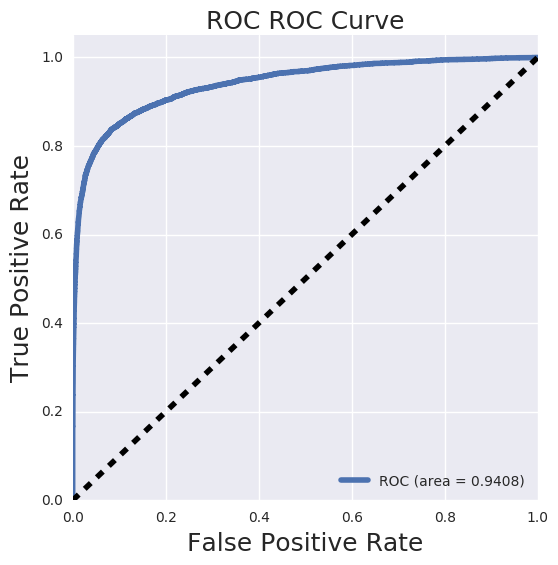

In [213]:
Y_score = log_gs.decision_function(X_test)
plot_roc(y_test, Y_score)

In [214]:
log_gs_coef = print_coefs(X_test, log_gs.best_estimator_)

Train/Test Model Coefficients:
        coef                         feature
0   0.363425                       loan_amnt
1  -0.025071                           grade
2   0.244046                       sub_grade
3   0.090527                      emp_length
4  -0.024647                      annual_inc
5   0.382847                             dti
6   0.020928                     delinq_2yrs
7   0.342675                  fico_range_low
8   0.017985                 fico_range_high
9   0.009558                  inq_last_6mths
10 -0.011063          mths_since_last_delinq
11  0.054376          mths_since_last_record
12 -0.422506                        open_acc
13 -0.021263                         pub_rec
14 -0.119594                       revol_bal
15 -0.078654                      revol_util
16 -0.258305                       total_acc
17  4.690557                      recoveries
18  6.214447         collection_recovery_fee
19 -2.054927            last_fico_range_high
20  0.059796     mths_si

In [215]:
log_gs_coef['coef_abs'] = np.abs(log_gs_coef['coef'])

In [216]:
log_gs_coef.sort_values('coef_abs', ascending=False)

,coef,feature,coef_abs
18,6.214447,collection_recovery_fee,6.214447
17,4.690557,recoveries,4.690557
19,-2.054927,last_fico_range_high,2.054927
12,-0.422506,open_acc,0.422506
44,0.392910,num_sats,0.392910
5,0.382847,dti,0.382847
0,0.363425,loan_amnt,0.363425
7,0.342675,fico_range_low,0.342675
42,0.270092,num_rev_accts,0.270092
16,-0.258305,total_acc,0.258305


In [217]:
log_gs.grid_scores_

[mean: 0.90886, std: 0.00076, params: {'penalty': 'l1', 'C': 0.01},
 mean: 0.90855, std: 0.00071, params: {'penalty': 'l2', 'C': 0.01},
 mean: 0.90886, std: 0.00071, params: {'penalty': 'l1', 'C': 0.1},
 mean: 0.90885, std: 0.00075, params: {'penalty': 'l2', 'C': 0.1},
 mean: 0.90893, std: 0.00076, params: {'penalty': 'l1', 'C': 1.0},
 mean: 0.90889, std: 0.00076, params: {'penalty': 'l2', 'C': 1.0}]

In [218]:
index_list = ['Decision Tree Model', 'Bagging Tree Modeld', 'Lasso Model', 'PCA Model', 'LendingClub.com Model',
              'GridsearchLog']

In [219]:
Compare = pd.DataFrame([dt_metrics, bagg_metrics, lasso_metrics, pca_metrics, grade_metrics, log_gs_metrics], index=[index_list])

In [223]:
cross_val_scores = ['.945','.956','.909','.479','.653','.909']

In [224]:
Compare['Cross-Val Score'] = cross_val_scores

In [225]:
Compare

,Accuracy,Area Under P-R Curve,Area Under Roc Curve,False Positve Rate,Precision,Recall,Cross-Val Score
Decision Tree Model,0.944917,0.549072,0.753088,0.029295,0.535149,0.535471,.945
Bagging Tree Modeld,0.951685,0.700043,0.917650,0.000114,0.990415,0.186373,.956
Lasso Model,0.908382,0.741254,0.940700,0.087216,0.377141,0.838477,.909
PCA Model,0.476377,0.072388,0.549929,0.531404,0.067242,0.597792,.479
LendingClub.com Model,0.653392,0.125441,0.705493,0.345846,0.104572,0.641283,.653
GridsearchLog,0.908144,0.740940,0.940827,0.087569,0.376640,0.840080,.909


In [ ]:
#LOOKING OVER THE RESULTS OF THE MODEL I WOULD CHOOSE USE A BAGGING TREE WITH A RANDOMFOREST CLASSIFIER AS THE MODEL 
#TO PRESENT TO INVESTORS.  EVEN FOR THOSE INVESTORS WHO LIKE TO GO CONSERVATIVE THE DECISION TREE MODEL ALSO PREDICTED
#THE LEAST FALSE POSITIVES.  


#I WOULD INFOMR INVESTORS TO PAY CLOSER ATTENTION TO THE APPLICANTS CREDIT REPORT MARKS ON 'RECOVERIES', 
#'COLLECTION_RECOVERY_FEES', 'LOAN AMOUT', 'DTI', THEIR LOW AND HIGH RANGE FICO SCORES AND ALSO THE AMOUNT OF CREDICT
#CARDS OPENED, CURRENT AND PAID OFF.  THESE FEATURES SEEM TO HAVE THE MOST SWAY OVER WHETHER AN APPLICANT WOULD DEFUALT 
#OR NOT.  